E:\Dev\src\ASP\Playground\Binder\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  return ax.plot(*args, **kwds)
E:\Dev\src\ASP\Playground\Binder\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  return ax.plot(*args, **kwds)
E:\Dev\src\ASP\Playground\Binder\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  return ax.plot(*args, **kwds)
E:\Dev\src\ASP\Playground\Binder\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  return ax.plot(*args, **kwds)
E:\Dev\src\ASP\Playground\Binder\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: Data has no positive values, and therefore cannot be log-scale

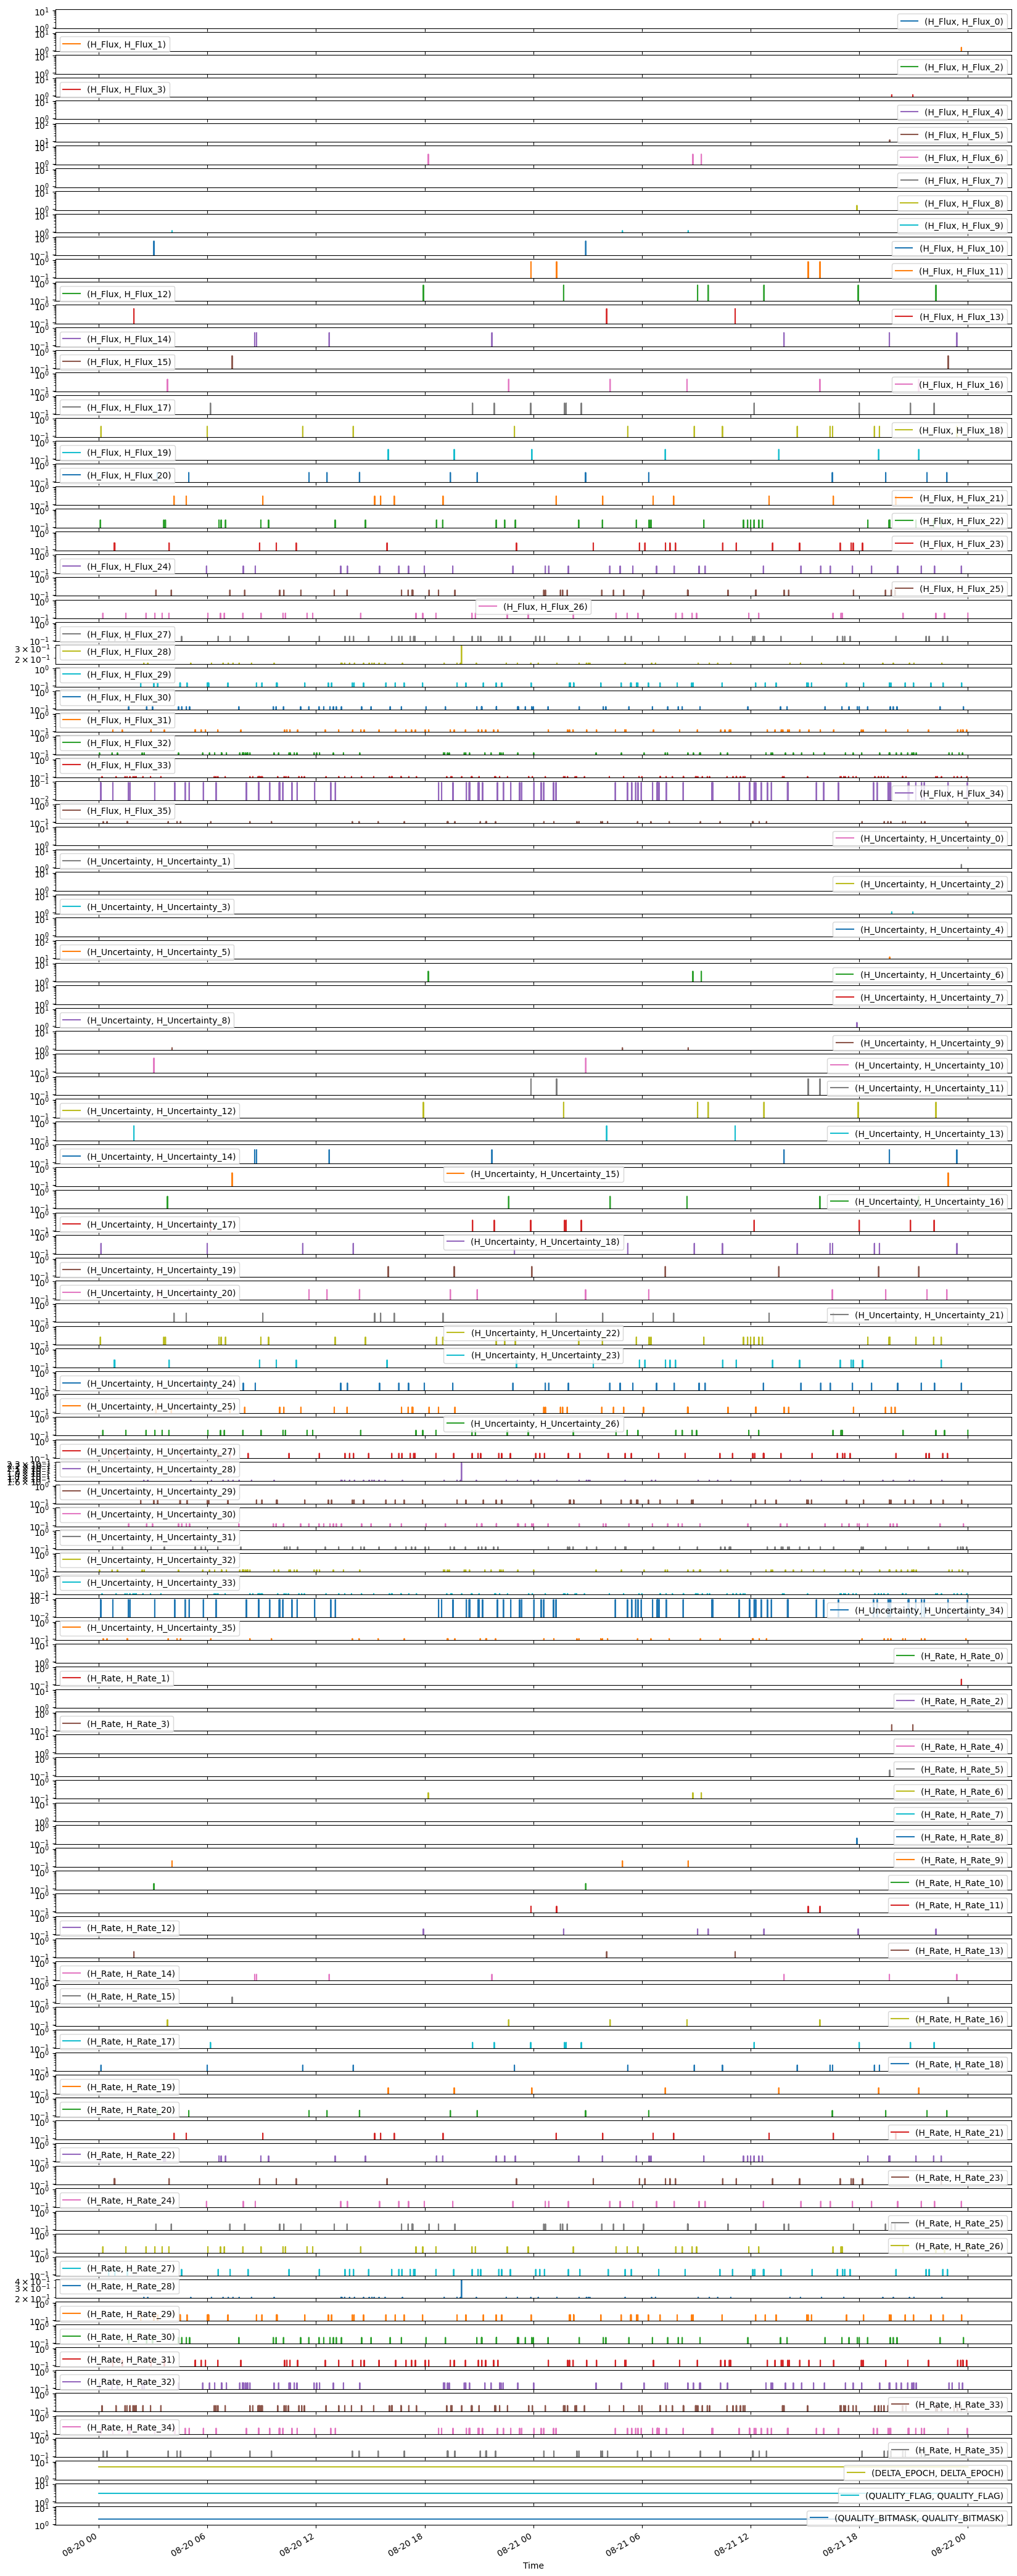

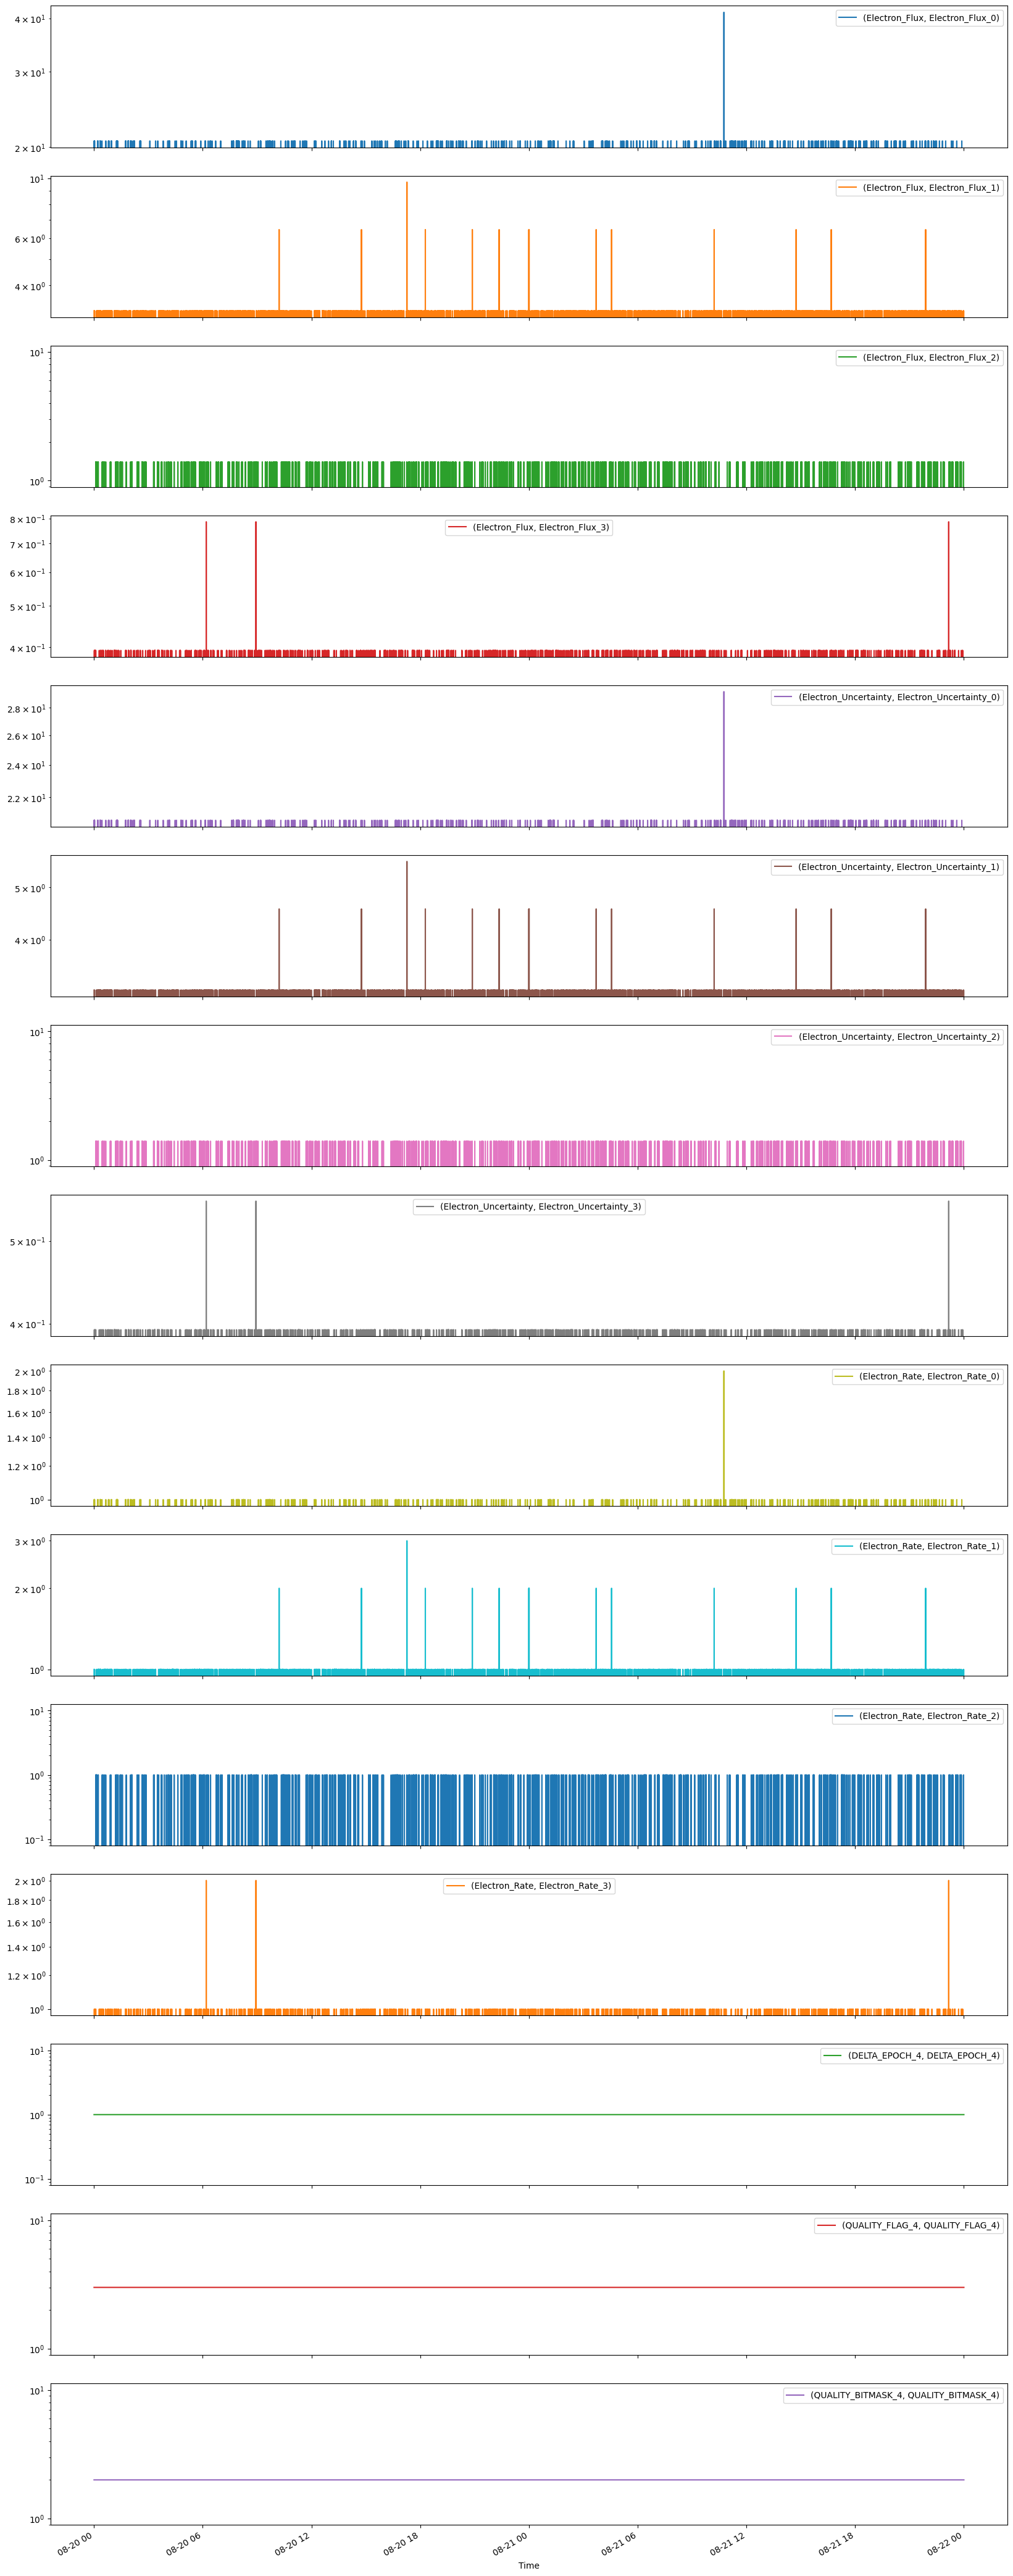

In [1]:
from matplotlib import pyplot as plt
from solo_epd_loader import epd_load

df_protons, df_electrons, energies = \
    epd_load(sensor='het', level='l2', startdate=20200820,
             enddate=20200821, viewing='sun',
             path='/home/userxyz/solo/data/')

# plot protons and alphas
ax = df_protons.plot(logy=True, subplots=True, figsize=(20, 60))
plt.show()

# plot electrons
ax = df_electrons.plot(logy=True, subplots=True, figsize=(20, 60))
plt.show()
